In [1]:
import pandas as pd 
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# The data is given in the form of an excel sheet 
# Open the excel sheet 
file_path = 'data/OECD_betterLifeIndex.xlsx'
sheet_name = 'PyhtonReadable'
df = pd.read_excel(file_path, sheet_name=sheet_name)
df

,Country,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net wealth,Labour market insecurity,Employment Rate,Long-term unemployment rate,Personal earnings,...,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care,OCED,Continent
0,Australia,..,19.4,..,37433,528768,3.1,73,1,55206,...,92,83.0,85,7.1,67,0.9,12.5,14.36,1.0,Oceania
1,Austria,0.8,20.8,1.6,37001,309637,2.3,72,1.3,53132,...,76,82.0,71,7.2,86,0.5,5.3,14.51,1.0,Europe
2,Belgium,0.7,20,2.1,34884,447607,2.4,65,2.3,54327,...,88,82.1,74,6.8,56,1.1,4.3,15.52,1.0,Europe
3,Canada,0.2,22.9,2.6,34421,478240,3.8,70,0.5,55342,...,68,82.1,89,7.0,78,1.2,3.3,14.57,1.0,North America
4,Chile,9.4,18.4,1.9,..,135787,7,56,..,26729,...,47,80.6,60,6.2,41,2.4,7.7,..,1.0,South America
5,Colombia,12.3,..,1,..,..,..,58,1.1,..,...,53,76.7,80,5.7,50,23.1,23.7,..,1.0,South America
6,Costa Rica,2.3,17,1.2,16517,..,..,55,1.5,..,...,66,80.5,73,6.3,47,10.0,22,..,1.0,North America
7,Czech Republic,0.5,23.4,1.5,26664,..,2.3,74,0.6,29885,...,62,79.3,62,6.9,77,0.7,4.5,..,1.0,Europe
8,Denmark,0.5,23.3,1.9,33774,149864,4.5,74,0.9,58430,...,85,81.5,70,7.5,85,0.5,1.1,..,1.0,Europe
9,Estonia,5.7,17,1.7,23784,188627,5.4,74,1.2,30720,...,64,78.8,57,6.5,79,1.9,2.2,14.98,1.0,Europe


In [2]:
df.columns = df.columns.str.strip()
chart2 = alt.Chart(df).mark_point().encode(
    x=alt.X('Country').sort('-y'),
    color=alt.value("#116EA1"),
    y='Homicide rate'
)
chart2 = chart2.configure(background='#babab8')
chart2

alt.Chart(...)

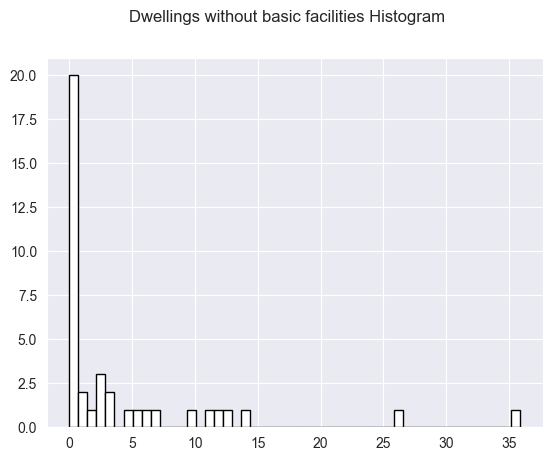

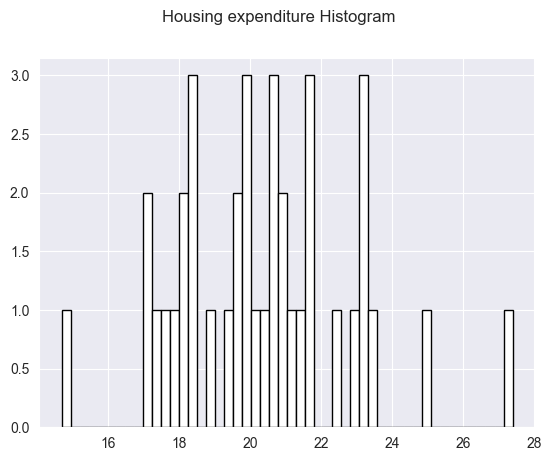

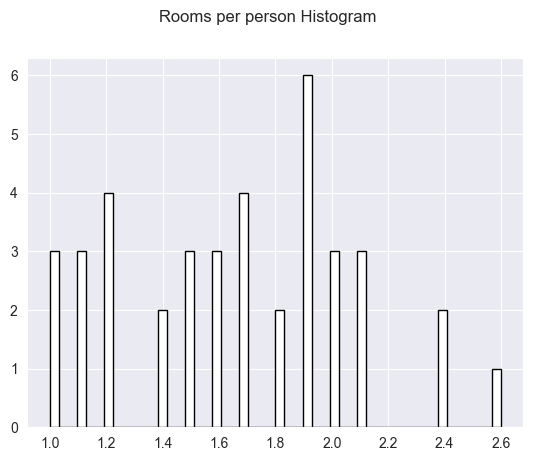

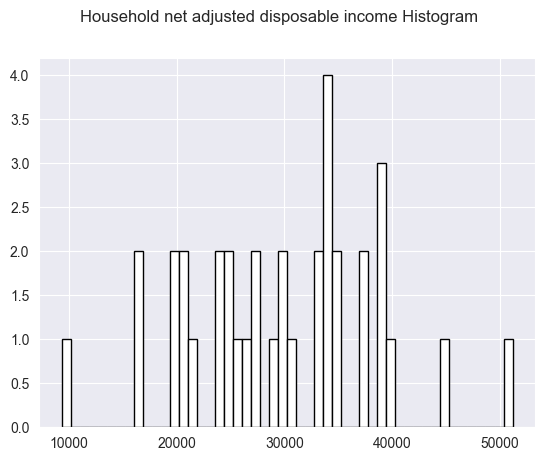

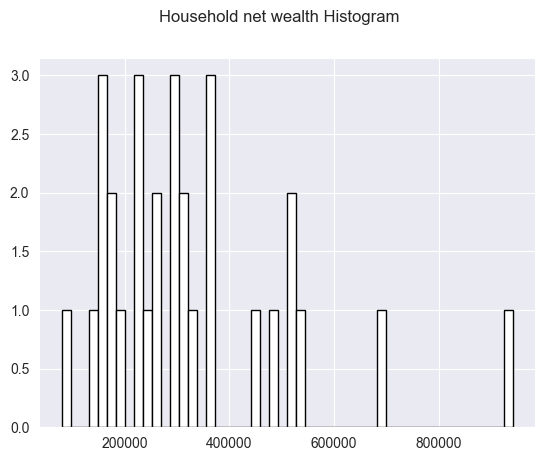

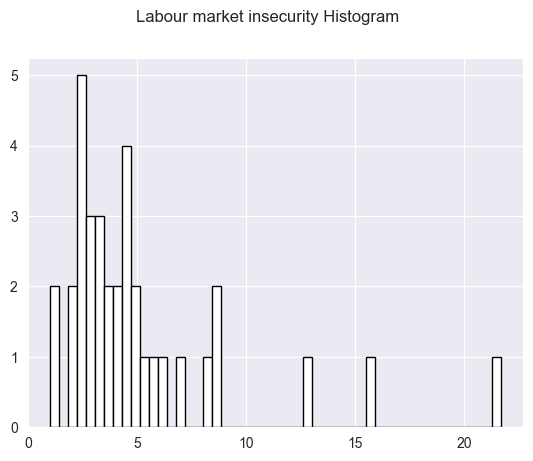

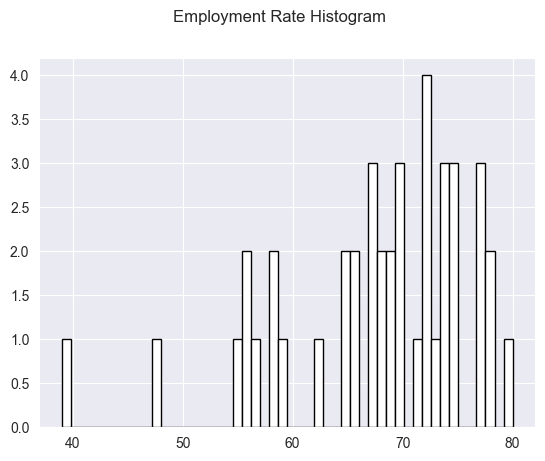

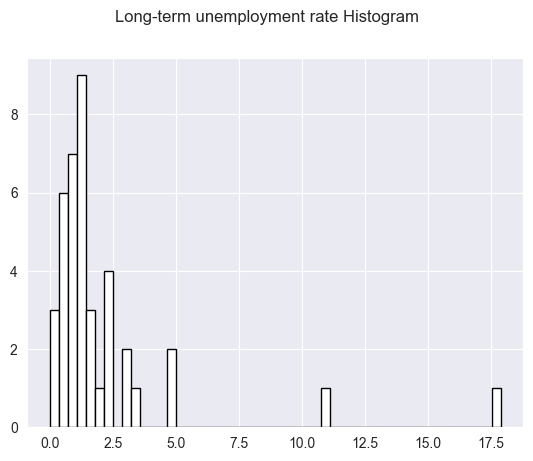

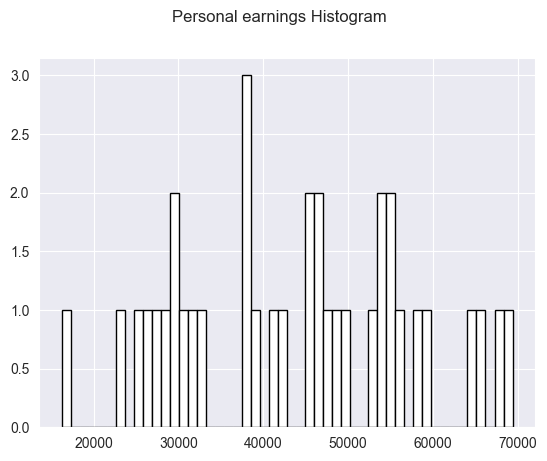

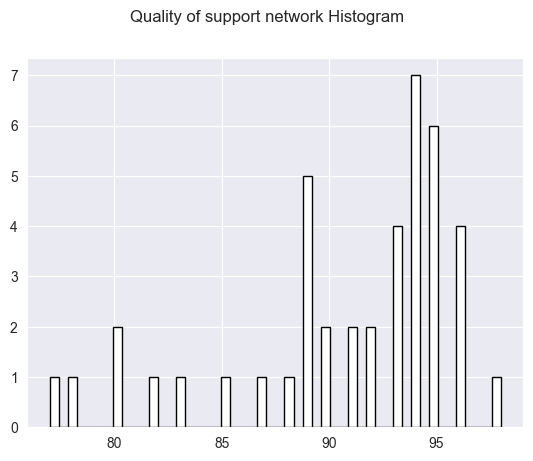

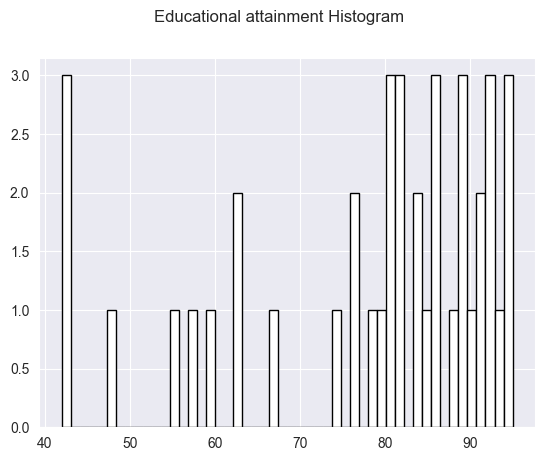

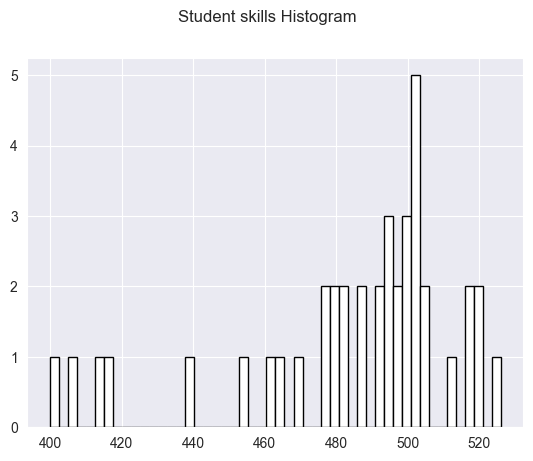

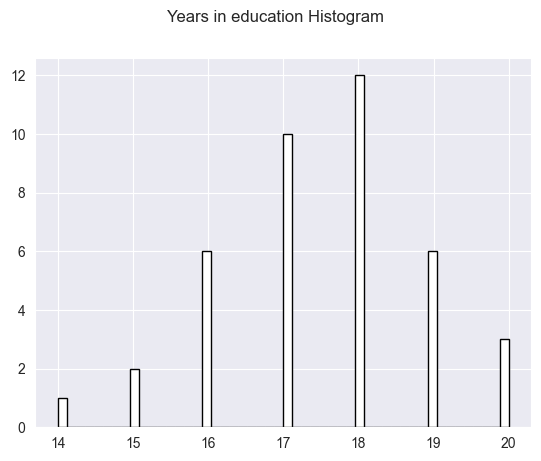

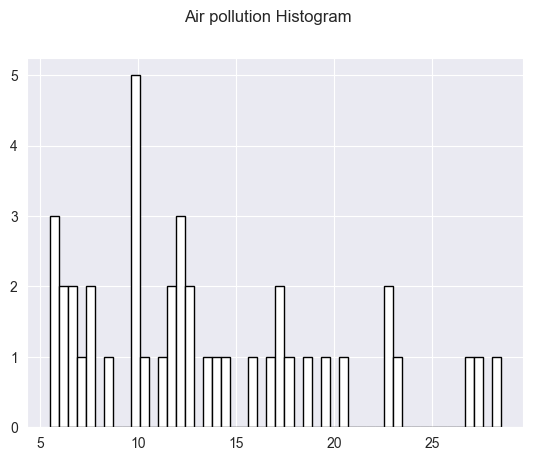

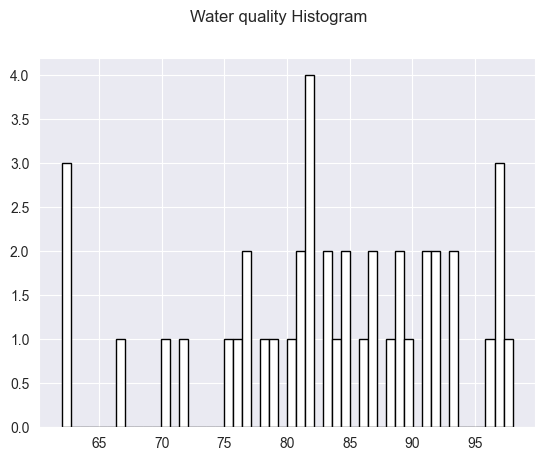

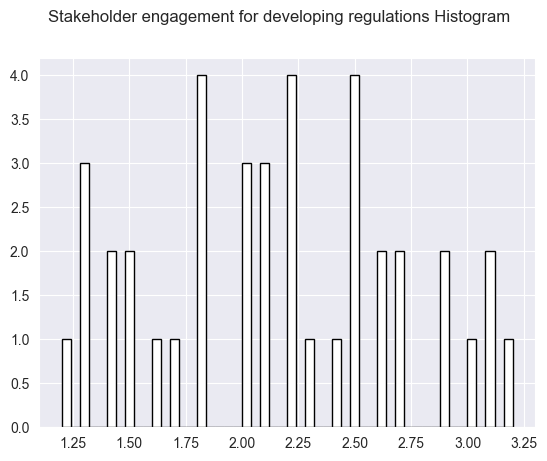

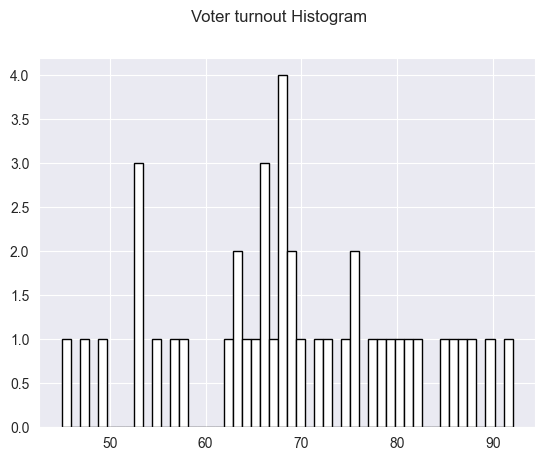

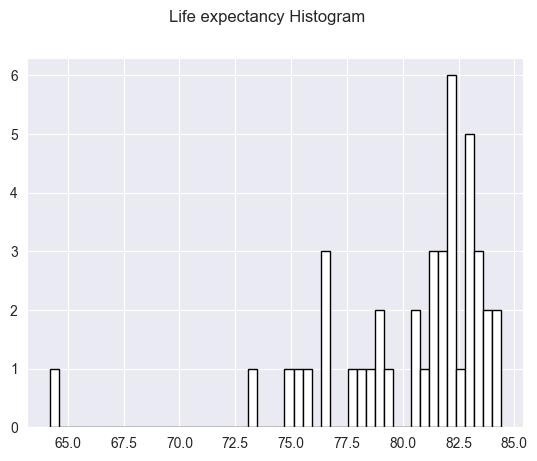

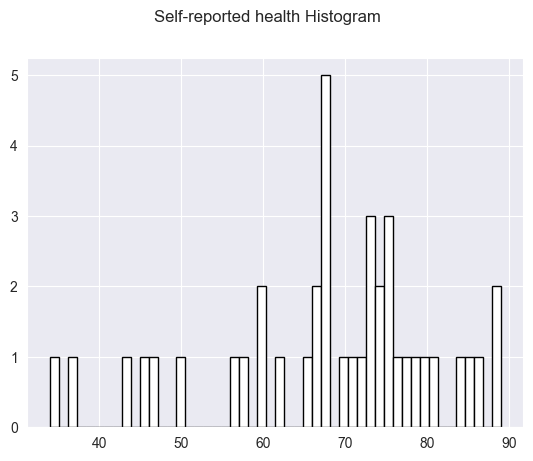

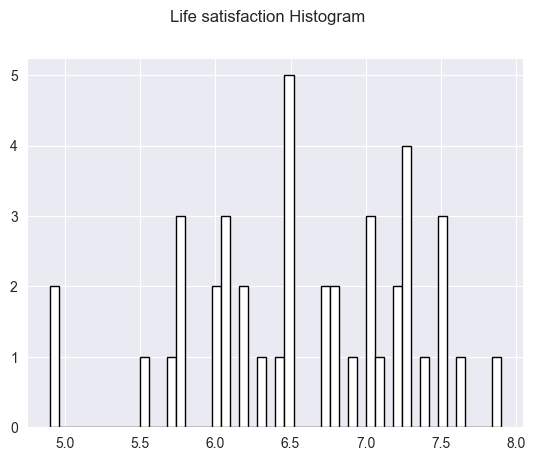

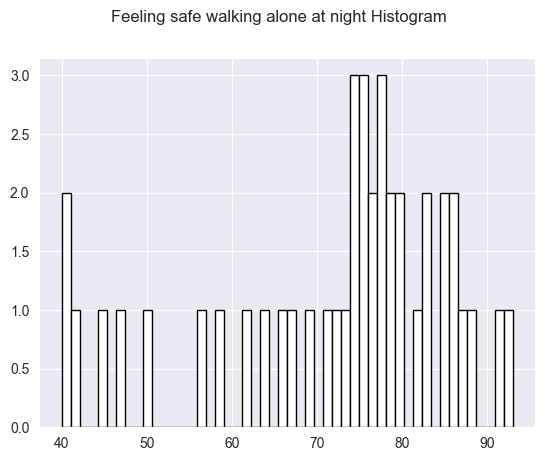

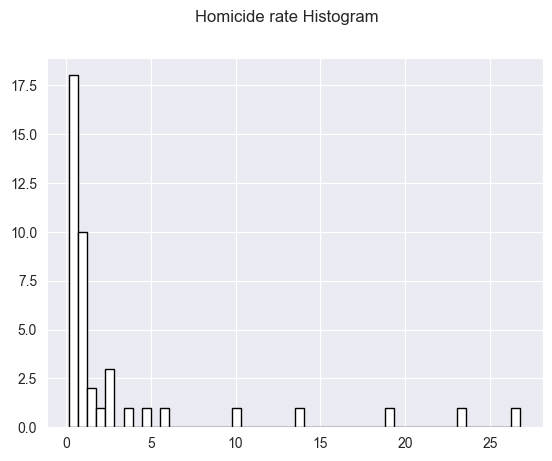

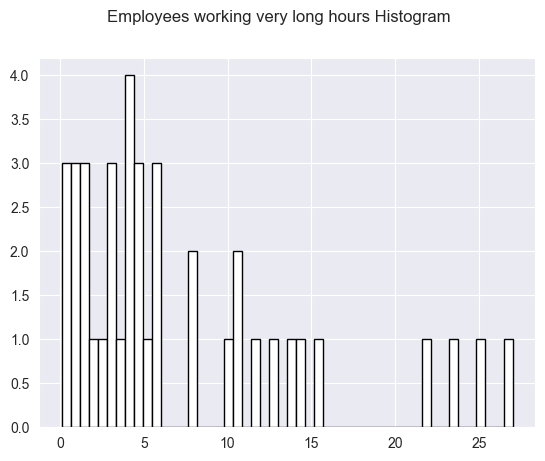

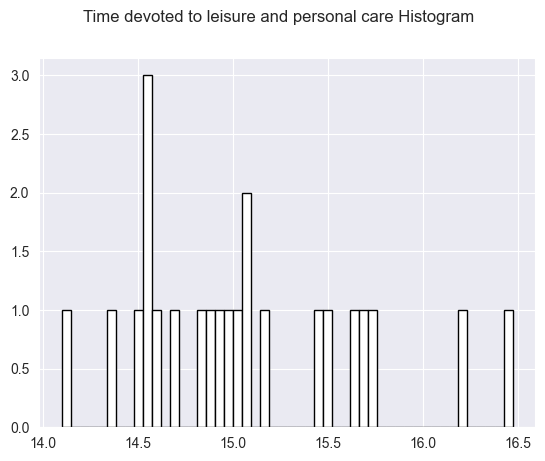

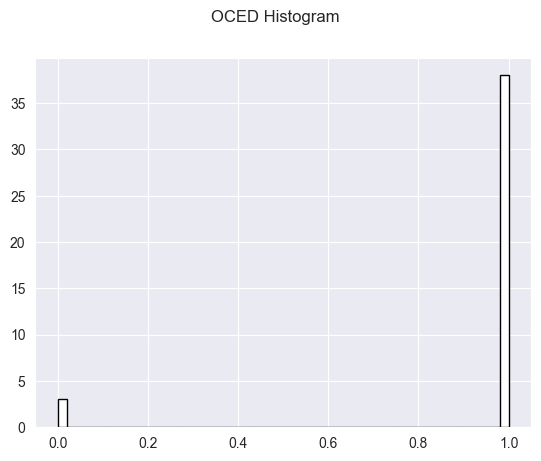

In [25]:
non_usable = ['Country', 'Continent']
df.replace('..', np.nan, inplace=True)
#selected = df.drop(columns=non_usable)
#correlation_matrix = selected.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm', fmt='0.5f', linewidths=.2,annot_kws={"size": 10, "rotation": 45})
#
#plt.title('Correlation Matrix')
#plt
df.describe()
include = [col for col in df.columns if col not in non_usable]
for col in include:
    ax =plt.hist(df[col].dropna(), bins=50, edgecolor='black', label=col, color='white')
    plt.suptitle(f'{col} Histogram')
    plt.show()
